# LSTM and CONVOLUTIONS for CLOSE PREDICTION

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Conv1D, Cropping1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")

# Set the seed
np.random.seed(39)
tf.random.set_seed(39)


Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/EconometricsLSTM/nifty_lagged_indicator.csv'

df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Unnamed: 0,X,Date,open,high,low,close,volume,Open,High,...,macd,rsi,ulti,volatility,roc,dema,atr,cci,obv,wr
0,2,2,2017-01-03,8195.25,8219.00,1,8189.05,135579793,8210.10,8211.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117899648,NaN
1,3,3,2017-01-04,8200.80,8218.45,1,8196.35,141064842,8195.25,8219.00,...,NaN,NaN,NaN,NaN,0.001204,NaN,8218.00,NaN,253479441,NaN
2,4,4,2017-01-05,8226.65,8282.55,1,8270.50,166577106,8200.80,8218.45,...,NaN,NaN,NaN,NaN,0.000891,NaN,8217.45,NaN,394544283,NaN
3,5,5,2017-01-06,8283.00,8306.50,1,8248.20,150211914,8226.65,8282.55,...,NaN,NaN,NaN,NaN,0.009006,NaN,8281.55,NaN,561121389,NaN
4,6,6,2017-01-09,8259.10,8260.30,1,8234.55,106756707,8283.00,8306.50,...,NaN,NaN,NaN,NaN,-0.002700,NaN,8305.50,NaN,410909475,NaN


# 1-STEP AHEAD
However we do not use a rollig window: we do not retrain the model after each prediction due to computational time

Data spitting, scaling and sequence preparation

In [3]:
# Select the features and target
FEATURES = ['Open','High','Low','Close',  'Volume', 'macd','rsi','ulti',
            'volatility','roc','dema','atr','cci','obv','wr']
TARGET   = 'close'

# Restrict the dataframe from the dates with no NaNs
df = df[df['Date'] >= '2017-02-13'].reset_index(drop=True)

# Keep test all 2019, train from start to end sept 2018, val last 3 months of 2019
train_end   = pd.to_datetime('2018-09-30')
val_start   = pd.to_datetime('2018-10-01')
val_end     = pd.to_datetime('2018-12-31')
test_start  = pd.to_datetime('2019-01-01')

# Hyperparameters for bulding the dataset (telescope, i.e. the len of the prediction
# output is set to 1: we focus on the single point 1-step ahead predction. Also
# stride is set to 1 so that the window moves one-at-a-time)
WINDOW    = 10
STRIDE    = 1
TELESCOPE = 1  # one-day ahead

# For each split, extend backwards by WINDOW days to allow full sequences (so we can alow full
# 2019 prediction, or validation on all last three months of 2018)
# The final +1 is given for purposes seen in the following loop
train_end_idx = df.index[df['Date'] <= train_end].max()+1
val_start_idx = df.index[df['Date'] >= val_start].min()+1
val_end_idx = df.index[df['Date'] <= val_end].max()+1
test_start_idx= df.index[df['Date'] >= test_start].min()+1

# Extend each split backwards by WINDOW rows
raw_train = df.iloc[: train_end_idx + 1]  # all rows up to train_end (INCLUDED)
raw_val   = df.iloc[ max(0, val_start_idx - WINDOW) : val_end_idx + 1 ]
raw_test  = df.iloc[ max(0, test_start_idx - WINDOW) : ]

print("Train slice rows:", raw_train.shape)
print("Val   slice rows:", raw_val.shape)
print("Test  slice rows:", raw_test.shape)

# Separate X/y
Xtr_df, ytr_df = raw_train[FEATURES], raw_train[[TARGET]]
Xvl_df, yvl_df = raw_val[FEATURES],   raw_val[[TARGET]]
Xte_df, yte_df = raw_test[FEATURES],  raw_test[[TARGET]]

# Min–Max scaling
x_scaler = MinMaxScaler().fit(Xtr_df)
Xtr = x_scaler.transform(Xtr_df)
Xvl = x_scaler.transform(Xvl_df)
Xte = x_scaler.transform(Xte_df)

y_scaler = MinMaxScaler().fit(ytr_df)
ytr = y_scaler.transform(ytr_df)
yvl = y_scaler.transform(yvl_df)
yte = y_scaler.transform(yte_df)

# Fuction to build the sequence
def build_sequences(X, y, dates, window=50, telescope=1, stride=1):
    Xs, ys, ds = [], [], []

    # We put -1 to keep the dim of the window correct. moreover, the dataset is
    # built so that in each row the features are the ones of the day before to predict
    # the close of the given day after: this is the reaosn why we are selecting
    # the element in start+window-1 (this is also consistent with how we defied the
    # train_end_idx, val_start_idx, ... previously)
    for start in range(0, len(X) - window - telescope+1, stride):
        Xs.append(X[start:start+window])
        ys.append(y[start+window-1:start+window+telescope-1])
        ds.append(dates[start+window-1])
    return np.array(Xs), np.array(ys), np.array(ds)


Xtr, ytr, dtr = build_sequences(Xtr, ytr, raw_train['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xvl, yvl, dvl = build_sequences(Xvl, yvl, raw_val  ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xte, yte, dte = build_sequences(Xte, yte, raw_test ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
# DATES CHECKED: CORRECT (dvl from 2018-10-01 to 2018-12-31 and dte 2019-01-01 to end with no overalapping)

print("Train preds:", len(dtr),
      "Val preds:", len(dvl),
      "Test preds:", len(dte))

Train slice rows: (404, 23)
Val   slice rows: (70, 23)
Test  slice rows: (254, 23)
Train preds: 394 Val preds: 60 Test preds: 244


Building the netural networ model + prediction

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,841 (1.66 MB)

 Trainable params: 435,841 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
25/25 - 8s - 325ms/step - loss: 0.0799 - val_loss: 0.0297 - learning_rate: 1.0000e-03
Epoch 2/200
25/25 - 2s - 78ms/step - loss: 0.0168 - val_loss: 0.0173 - learning_rate: 1.0000e-03
Epoch 3/200
25/25 - 2s - 67ms/step - loss: 0.0108 - val_loss: 0.0106 - learning_rate: 1.0000e-03
Epoch 4/200
25/25 - 2s - 81ms/step - loss: 0.0107 - val_loss: 0.0087 - learning_rate: 1.0000e-03
Epoch 5/200
25/25 - 1s - 37ms/step - loss: 0.0119 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 6/200
25/25 - 1s - 37ms/step - loss: 0.0097 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 7/200
25/25 - 1s - 37ms/step - loss: 0.0099 - val_loss: 0.0101 - learning_rate: 1.0000e-03
Epoch 8/200
25/25 - 1s - 50ms/step - loss: 0.0091 - val_loss: 0.0054 - learning_rate: 1.0000e-03
Epoch 9/200
25/25 - 1s - 54ms/step - loss: 0.0120 - val_loss: 0.0078 - learning_rate: 1.0000e-03
Epoch 10/200
25/25 - 2s - 85ms/step - loss: 0.0101 - val_loss: 0.0062 - learning_rate: 1.0000e-03
Epoch 11/200
25/25 - 1s - 36

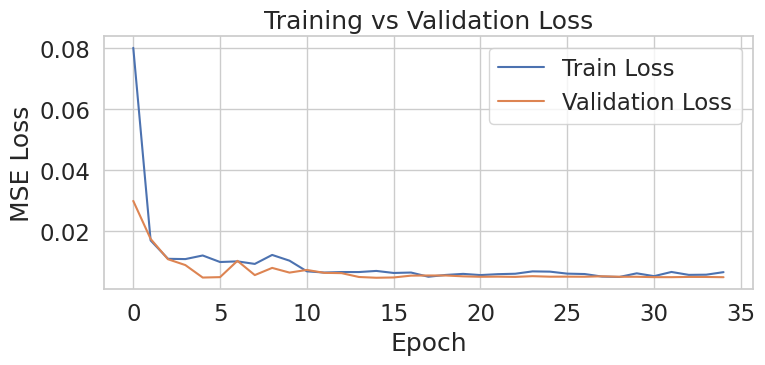

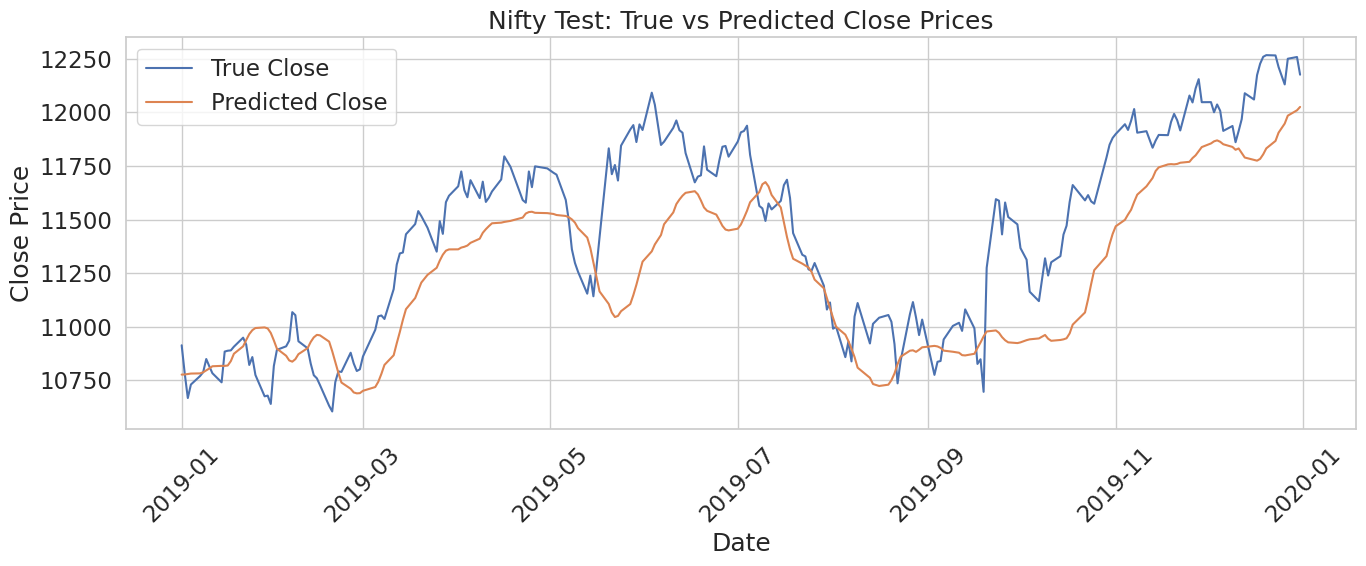

In [4]:
# Build Conv-LSTM model
def build_conv_lstm(input_shape, telescope):

    # Take the
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv1D(1, 3, padding='same')(x)         # shape: (window, 1)
    crop = WINDOW - telescope
    out = layers.Cropping1D((crop, 0))(x)              # shape: (telescope, 1)
    model = models.Model(inp, out)
    model.compile(loss='mse', optimizer='adam')
    return model

model = build_conv_lstm((WINDOW, len(FEATURES)), TELESCOPE)
model.summary()

# Train once on train+val
es = callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau('val_loss', patience=5, factor=0.1, min_lr=1e-5)

history = model.fit(
    Xtr, ytr,
    validation_data=(Xvl, yvl),
    epochs=200, batch_size=16,
    callbacks=[es, rl],
    verbose=2
)

# Evaluate on test
pred = model.predict(Xte).reshape(-1,)
true = yte.reshape(-1,)
# Inverse scale
pred_flat = y_scaler.inverse_transform(pred.reshape(-1,1)).flatten()
true_flat = y_scaler.inverse_transform(true.reshape(-1,1)).flatten()

print(f"Test MSE: {mean_squared_error(true_flat, pred_flat):.4f}")
print(f"Test MAE: {mean_absolute_error(true_flat, pred_flat):.4f}")

# Directional accuracy
dirs = []
for i in range(len(Xte)):
    last_close = x_scaler.inverse_transform(Xte[i])[-1, FEATURES.index('Close')]
    dirs.append(int((pred_flat[i]>last_close)==(true_flat[i]>last_close)))
print(f"Directional Accuracy: {100*np.mean(dirs):.2f}%")

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Plot ALL test predictions vs true with dates
results = pd.DataFrame({'Date': dte, 'True_Close': true_flat, 'Pred_Close': pred_flat})
results.set_index('Date', inplace=True)
plt.figure(figsize=(14,6))
plt.plot(results.index, results['True_Close'], label='True Close')
plt.plot(results.index, results['Pred_Close'], label='Predicted Close')
plt.xticks(rotation=45); plt.xlabel('Date'); plt.ylabel('Close Price')
plt.title('Nifty Test: True vs Predicted Close Prices')
plt.legend(); plt.tight_layout(); plt.show()


# Addition of SP500 data
(the rest is the same)

In [8]:
# Load Nifty50 and SPY data

SPY_path = '/content/drive/MyDrive/EconometricsLSTM/common_daily_SPY_filtered_lag_tech_ind.csv'
NIFTY_path = '/content/drive/MyDrive/EconometricsLSTM/common_daily_nifty_filtered_lag_tech_ind.csv'

nifty = pd.read_csv(NIFTY_path, parse_dates=['Date'])
spy   = pd.read_csv(SPY_path, parse_dates=['Date'])

# Rename SPY OHLCV columns for merging
spy = spy[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(
    columns={
        'Open': 'Open_SPY',
        'High': 'High_SPY',
        'Low': 'Low_SPY',
        'Close': 'Close_SPY',
        'Volume': 'Volume_SPY'
    }
)

# Shift SPY features by one day to use previous-day values
spy[['Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Volume_SPY']] = \
    spy[['Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Volume_SPY']].shift(1)

# Merge on Date, keep only dates present in both
df = pd.merge(nifty, spy, on='Date', how='inner')



In [6]:
# Select the features and target

FEATURES = ['Open','High','Low','Close', 'Volume', 'Open_SPY', 'High_SPY', 'Low_SPY',
            'Close_SPY', 'Volume_SPY', 'macd','rsi','ulti','volatility','roc','dema','atr','cci',
            'obv','wr']
TARGET   = 'close'

# Restrict the dataframe from the dates with no NaNs
df = df[df['Date'] >= '2017-02-14'].reset_index(drop=True)

# Keep test all 2019, train from start to end sept 2018, val last 3 months of 2019
train_end   = pd.to_datetime('2018-09-30')
val_start   = pd.to_datetime('2018-10-01')
val_end     = pd.to_datetime('2018-12-31')
test_start  = pd.to_datetime('2019-01-01')

# Hyperparameters for bulding the dataset (telescope, i.e. the len of the prediction
# output is set to 1: we focus on the single point 1-step ahead predction. Also
# stride is set to 1 so that the window moves one-at-a-time)
WINDOW    = 10
STRIDE    = 1
TELESCOPE = 1  # one-day ahead

# For each split, extend backwards by WINDOW days to allow full sequences (so we can alow full
# 2019 prediction, or validation on all last three months of 2018)
# The final +1 is given for purposes seen in the following loop
train_end_idx = df.index[df['Date'] <= train_end].max()+1
val_start_idx = df.index[df['Date'] >= val_start].min()+1
val_end_idx = df.index[df['Date'] <= val_end].max()+1
test_start_idx= df.index[df['Date'] >= test_start].min()+1

# Extend each split backwards by WINDOW rows
raw_train = df.iloc[: train_end_idx + 1]  # all rows up to train_end (INCLUDED)
raw_val   = df.iloc[ max(0, val_start_idx - WINDOW) : val_end_idx + 1 ]
raw_test  = df.iloc[ max(0, test_start_idx - WINDOW) : ]

print("Train slice rows:", raw_train.shape)
print("Val   slice rows:", raw_val.shape)
print("Test  slice rows:", raw_test.shape)

# Separate X/y
Xtr_df, ytr_df = raw_train[FEATURES], raw_train[[TARGET]]
Xvl_df, yvl_df = raw_val[FEATURES],   raw_val[[TARGET]]
Xte_df, yte_df = raw_test[FEATURES],  raw_test[[TARGET]]

# Min–Max scaling
x_scaler = MinMaxScaler().fit(Xtr_df)
Xtr = x_scaler.transform(Xtr_df)
Xvl = x_scaler.transform(Xvl_df)
Xte = x_scaler.transform(Xte_df)

y_scaler = MinMaxScaler().fit(ytr_df)
ytr = y_scaler.transform(ytr_df)
yvl = y_scaler.transform(yvl_df)
yte = y_scaler.transform(yte_df)

Xtr, ytr, dtr = build_sequences(Xtr, ytr, raw_train['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xvl, yvl, dvl = build_sequences(Xvl, yvl, raw_val  ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xte, yte, dte = build_sequences(Xte, yte, raw_test ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)

print("Train preds:", len(dtr),
      "Val preds:", len(dvl),
      "Test preds:", len(dte))

Train slice rows: (392, 29)
Val   slice rows: (68, 29)
Test  slice rows: (247, 29)
Train preds: 382 Val preds: 58 Test preds: 237


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,401 (1.67 MB)

 Trainable params: 438,401 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 - 11s - 442ms/step - loss: 0.0580 - val_loss: 0.0285 - learning_rate: 1.0000e-03
Epoch 2/200
24/24 - 1s - 39ms/step - loss: 0.0136 - val_loss: 0.0185 - learning_rate: 1.0000e-03
Epoch 3/200
24/24 - 1s - 53ms/step - loss: 0.0138 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 4/200
24/24 - 1s - 39ms/step - loss: 0.0087 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 5/200
24/24 - 1s - 52ms/step - loss: 0.0097 - val_loss: 0.0063 - learning_rate: 1.0000e-03
Epoch 6/200
24/24 - 1s - 51ms/step - loss: 0.0086 - val_loss: 0.0065 - learning_rate: 1.0000e-03
Epoch 7/200
24/24 - 1s - 43ms/step - loss: 0.0078 - val_loss: 0.0066 - learning_rate: 1.0000e-03
Epoch 8/200
24/24 - 1s - 62ms/step - loss: 0.0098 - val_loss: 0.0088 - learning_rate: 1.0000e-03
Epoch 9/200
24/24 - 2s - 67ms/step - loss: 0.0087 - val_loss: 0.0117 - learning_rate: 1.0000e-03
Epoch 10/200
24/24 - 2s - 67ms/step - loss: 0.0072 - val_loss: 0.0053 - learning_rate: 1.0000e-04
Epoch 11/200
24/24 - 2s - 7

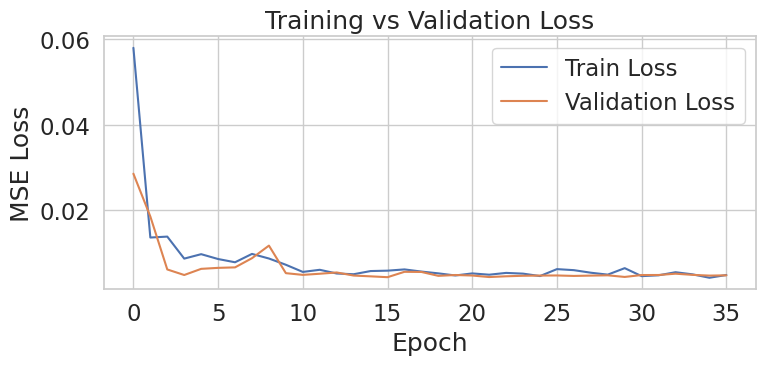

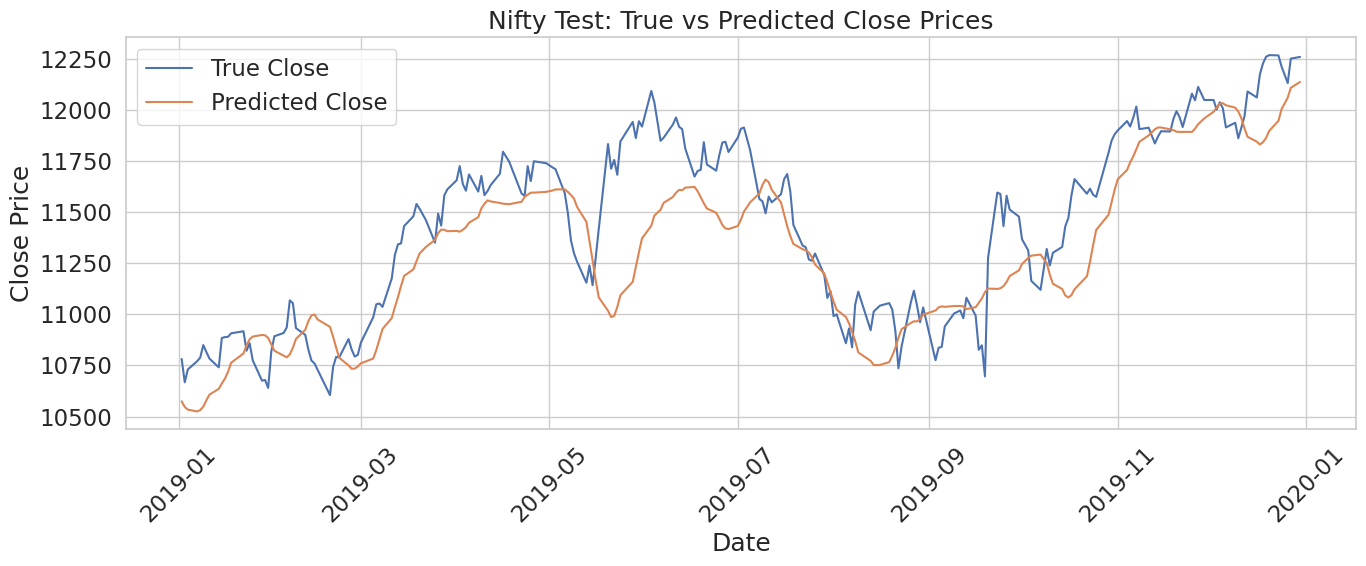

In [7]:
model = build_conv_lstm((WINDOW, len(FEATURES)), TELESCOPE)
model.summary()

# Train once on train+val
es = callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau('val_loss', patience=5, factor=0.1, min_lr=1e-5)

history = model.fit(
    Xtr, ytr,
    validation_data=(Xvl, yvl),
    epochs=200, batch_size=16,
    callbacks=[es, rl],
    verbose=2
)


# Evaluate on test
pred = model.predict(Xte).reshape(-1,)
true = yte.reshape(-1,)
# Inverse scale
pred_flat = y_scaler.inverse_transform(pred.reshape(-1,1)).flatten()
true_flat = y_scaler.inverse_transform(true.reshape(-1,1)).flatten()

print(f"Test MSE: {mean_squared_error(true_flat, pred_flat):.4f}")
print(f"Test MAE: {mean_absolute_error(true_flat, pred_flat):.4f}")

# Directional accuracy
dirs = []
for i in range(len(Xte)):
    last_close = x_scaler.inverse_transform(Xte[i])[-1, FEATURES.index('Close')]
    dirs.append(int((pred_flat[i]>last_close)==(true_flat[i]>last_close)))
print(f"Directional Accuracy: {100*np.mean(dirs):.2f}%")

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ALL test predictions vs true with dates
results = pd.DataFrame({'Date': dte, 'True_Close': true_flat, 'Pred_Close': pred_flat})
results.set_index('Date', inplace=True)
plt.figure(figsize=(14,6))
plt.plot(results.index, results['True_Close'], label='True Close')
plt.plot(results.index, results['Pred_Close'], label='Predicted Close')
plt.xticks(rotation=45); plt.xlabel('Date'); plt.ylabel('Close Price')
plt.title('Nifty Test: True vs Predicted Close Prices')
plt.legend(); plt.tight_layout(); plt.show()
